A common question in computer science is to measure the [computational complexity of algorithms](https://en.wikipedia.org/wiki/Computational_complexity_theory). I've recently taken a programming test where the two aspects of programming that were measured as part of the test were **correctness** and **speed**, as each programming task had an assigned target complexity ($\mathcal{O}(n\log{}n)$ or $\mathcal{O}(n)$ for example).

This is obviously a very important topic, for instance when working on scaling a particular algorithm for a size of data. Usually, the algorithm itself can be analyzed to determine its complexity. For instance, if your input is an array and you're looping over all elements, then this will have a $\mathcal{O}(n)$ complexity, where $n$ is the size of the array. If you're doing two nested loops, then the complexity is $\mathcal{O}(n^2)$. 

But it's not always possible to actually be sure of the complexity before you write the algorithm. For instance when you use built-in functions for which the complexity is not straightforward. A simpler alternative is then to measure the timings of your function as a function of the input array size. I like this practical benchmarking idea, which we will demonstrate on three implementations that compute the [Fibonacci numbers](https://en.wikipedia.org/wiki/Fibonacci_number). 

# First implementation: recursion 

The first implementation I'd like to use if the recursive one:

In [1]:
def fib_rec(n):
    "Computes Fibonacci number recursively."
    if n == 0: 
        return 0
    elif n == 1: 
        return 1
    else:
        return fib_rec(n-1) + fib_rec(n-2)

Let's test this:

In [2]:
[fib_rec(i) for i in range(10)]

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34]

# Second implementation: loop style 

The second one is a loop style implementation:

In [3]:
def fib_loop(n):
    "Computes Fibonacci number by iterating over all elements."
    if n == 0: 
        return 0
    elif n == 1: 
        return 1
    else: 
        a, b = 0, 1
        for i in range(n - 1):
            a, b = b, a + b
        return b

In [4]:
[fib_loop(i) for i in range(10)]

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34]

# Third implementation: log time 

The last implementation makes use of the fact that the Fibonacci numbers can be computed a [matrix multiplication in log time](http://kukuruku.co/hub/algorithms/the-nth-fibonacci-number-in-olog-n). The idea here is to decompose the number $n$ in powers of two to yield a speedup.

It is based on the following things:

- decompose $n$ in a sum of powers of 2
- compute the $Q$ matrix exponents up to the highest power of two needed
- assemble the result

Let's look at this in a step by step process. First, let's decompose any number in powers of 2. We use a simple iterative algorithm:

In [5]:
from math import log2

def powers_of_two(n):
    "Returns a list of the powers of 2 that sum to equal n."
    powers = []
    remainder = n
    while remainder != 0:
        powers.append(int(log2(remainder)))
        remainder -= 2 ** powers[-1]
    return powers

In [6]:
[(i, powers_of_two(i)) for i in range(1, 10)]

[(1, [0]),
 (2, [1]),
 (3, [1, 0]),
 (4, [2]),
 (5, [2, 0]),
 (6, [2, 1]),
 (7, [2, 1, 0]),
 (8, [3]),
 (9, [3, 0])]

The second step is to compute the matrices needed for rapid multiplication. We will store each 2x2 matrix as a tuple. We also need to define a matrix multiplication operation:

In [7]:
def precompute_matrix(max_power):
    "Precomputes matrix until highest power of 2 needed."
    matrix_powers = {}
    matrix_powers[0] = (1, 1, 1, 0)
    for i in range(1, max_power + 1):
        matrix_powers[i] = matrix_mult(matrix_powers[i-1], matrix_powers[i-1])
    return matrix_powers

def matrix_mult(mat1, mat2):
    "Multiplication of 2x2 matrices."
    a, b, c, d = mat1
    e, f, g, h = mat2
    return (a*e + b*g, 
            a*f + b*h,
            c*e + d*g,
            c*f + d*h)

Let's check that the results are correct for the first few powers:

In [8]:
precompute_matrix(4)

{0: (1, 1, 1, 0),
 1: (2, 1, 1, 1),
 2: (5, 3, 3, 2),
 3: (34, 21, 21, 13),
 4: (1597, 987, 987, 610)}

In [9]:
import numpy as np
from numpy.linalg import matrix_power

In [10]:
matrix_power(np.array([[1, 1], [1, 0]]), 2)

array([[2, 1],
       [1, 1]])

In [11]:
matrix_power(np.array([[1, 1], [1, 0]]), 4)

array([[5, 3],
       [3, 2]])

In [12]:
matrix_power(np.array([[1, 1], [1, 0]]), 8)

array([[34, 21],
       [21, 13]])

In [13]:
matrix_power(np.array([[1, 1], [1, 0]]), 16)

array([[1597,  987],
       [ 987,  610]])

This seems good, so we can now assemble the final parts of our log fibonacci function:

In [14]:
from math import sqrt

def fib_log(n):
    "Computes Fibonacci number in logarithmic time."
    if n == 0: return 0
    terms = powers_of_two(n)
    matrix_terms = precompute_matrix(max(terms))
    result = (1, 0, 0, 1)
    for term in terms:
        result = matrix_mult(result, matrix_terms[term])
    return result[1]

In [15]:
[fib_log(i) for i in range(10)]

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34]

# Measuring timings

At this point, one can wonder: what is the complexity of these three implementations? Except for the loop one, which is linear, it's not easy to tell right away. That's why, I suggest, we just measure this.

Measuring is quite easy, in fact. Let's just create a timing function, that accepts a function as an argument and a number.

In [16]:
import time

def time_func(func, *arg):
    "Times the execution of a function. Result is in seconds."
    tic = time.clock()
    func(*arg)
    toc = time.clock()
    return toc - tic

Let's see if it works:

In [17]:
time_func(fib_rec, 32)

1.2619419745651634

In [18]:
time_func(fib_loop, 200000)

0.4757292146374297

In [19]:
time_func(fib_log, 1000000)

0.47338340004959445

# Comparison of the three implementations using a plot 

With this tool, we can devise a test case for which we can compare all three implementations.

In [20]:
test_case_rec = [2, 4, 8, 16, 24, 26, 28, 30, 32]
test_case_loop = [10, 100, 200, 300, 500, 1000, 2000, 5000, 10000, 20000, 50000, 75000, 100000]
test_case_power = [10, 100, 200, 300, 500, 1000]

We use different test cases for each algorithm as will become clear in a second.

In [21]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

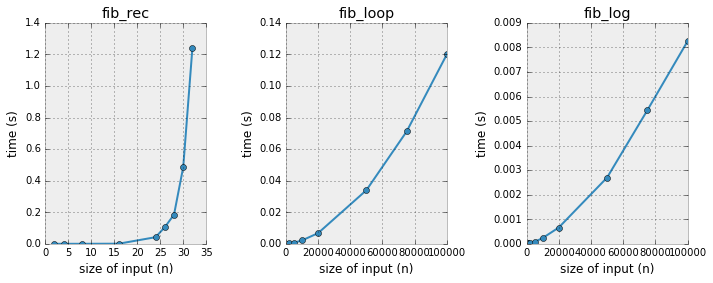

In [22]:
plt.figure(figsize=(10, 4))
for ind, func, tc in zip(range(1, 4), 
                        [fib_rec, fib_loop, fib_log],
                        [test_case_rec, test_case_loop, test_case_loop]):
    timings = [time_func(func, test) for test in tc]
    plt.subplot(1, 3, ind)
    plt.plot(tc, timings, '-o')
    plt.xlabel('size of input (n)')
    plt.ylabel('time (s)')
    plt.title("{}".format(func.__name__))
plt.tight_layout()

We can put that same plot on the same axis to see things more concretely:

(-1000, 100000.0)

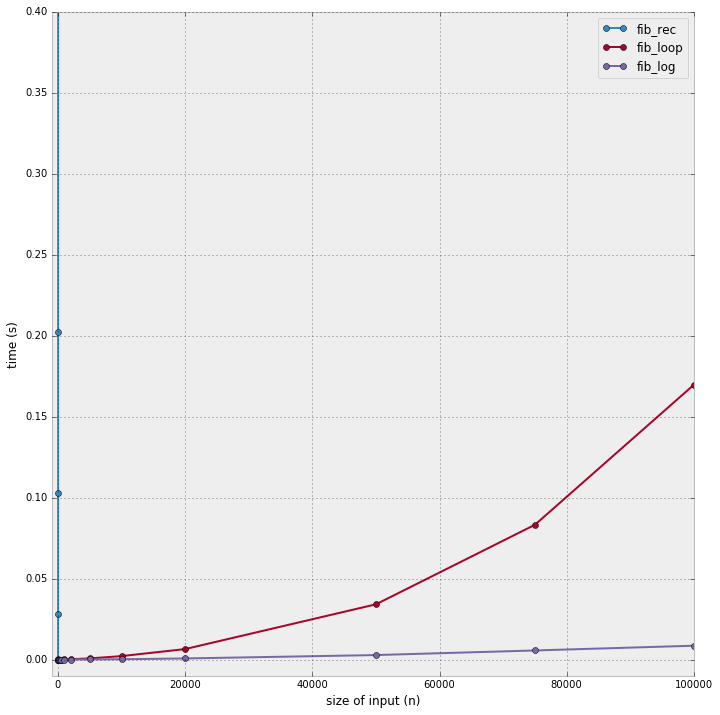

In [31]:
plt.figure(figsize=(10, 10))
for ind, func, tc in zip(range(1, 4), 
                        [fib_rec, fib_loop, fib_log],
                        [test_case_rec, test_case_loop, test_case_loop]):
    timings = [time_func(func, test) for test in tc]
    plt.plot(tc, timings, '-o', label="{}".format(func.__name__))
    plt.xlabel('size of input (n)')
    plt.ylabel('time (s)')
plt.tight_layout()
plt.legend()
plt.ylim(-0.01, 0.4)
plt.xlim(-1000, 1e5)

What we see above is quite interesting:

- the recursive implementation explodes so much it doesn't even show on the plot (effectively making any usage above n=32 unpractical)
- the loop style scales better
- the log time implementation fares even better than the loop style

# Conclusions 

Time for some takeaways. As the last plot has shown, the log implementation is definitely the fastest. The recursive implementation, while true to the spirit of the "sequence style definition" of the Fibonacci numbers is **very** impractical. It turns out that a straightforward way of making it faster is to memoize it, as [this blog post shows in the context of dynamic programming](https://jeremykun.com/2012/01/12/a-spoonful-of-python/). Another thought is that the algorithm's complexity effectively makes it tractable for large cases or just don't. If all you can come up with is something like the recursive implementation, there's many problems that will not be tractable (I'm thinking in terms of [project Euler problems](https://projecteuler.net/) here). 

This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20160531_MeasuringComplexityAlgorithm.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20160531_MeasuringComplexityAlgorithm.ipynb).